<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/master/3_red_neuronal_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [ ]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Residuo.csv")
modo_1["FECHA"] = pd.to_datetime(modo_1["FECHA"],format='%Y-%m-%d')
modo_2["FECHA"] = pd.to_datetime(modo_2["FECHA"],format='%Y-%m-%d')
modo_3["FECHA"] = pd.to_datetime(modo_3["FECHA"],format='%Y-%m-%d')
modo_4["FECHA"] = pd.to_datetime(modo_4["FECHA"],format='%Y-%m-%d')
modo_5["FECHA"] = pd.to_datetime(modo_5["FECHA"],format='%Y-%m-%d')
residuo["FECHA"] = pd.to_datetime(residuo["FECHA"],format='%Y-%m-%d')
modo_1.set_index("FECHA", inplace=True)
modo_2.set_index("FECHA", inplace=True)
modo_3.set_index("FECHA", inplace=True)
modo_4.set_index("FECHA", inplace=True)
modo_5.set_index("FECHA" ,inplace=True)
residuo.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

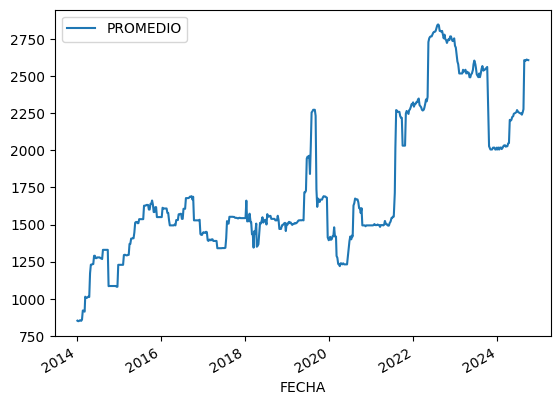

In [ ]:
datos_emd =modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd.plot()

In [ ]:
datos_emd.describe()

,PROMEDIO
count,554.000000
mean,1746.012635
std,484.698883
min,848.000000
25%,1448.000000
50%,1543.000000
75%,2162.500000
max,2850.000000


In [ ]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
import optuna
from keras.optimizers import RMSprop

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(Dense(trial.suggest_int('units', 7, 70), input_shape=(1,PASOS))) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(Dense(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh')) # Capas ocultas con unidades variables
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

In [ ]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

# Modelamos Modo 1

In [ ]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434


In [ ]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values
datos_validacion_m1_values = datos_validacion_m1.values
datos_testeo_m1_values = datos_testeo_m1.values

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


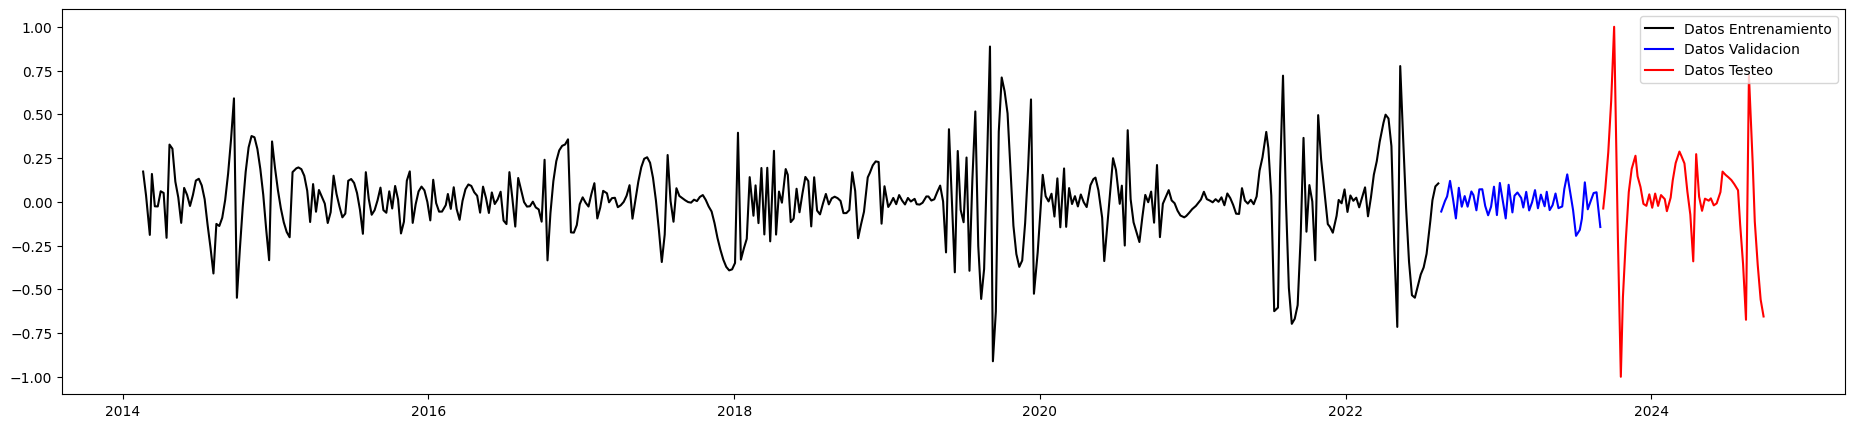

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
def modeloRD_m1():
  modelo = Sequential()
  modelo.add(Dense(units=47, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=28,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0083), loss='mse')
  return modelo

In [ ]:
modelo = modeloRD_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0823
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0448
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0435
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0428
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0639
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0480
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0449
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0423
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0441
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0421
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360
Epoch 16/40
63/63 ━━━━━━━━━━━━

In [ ]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


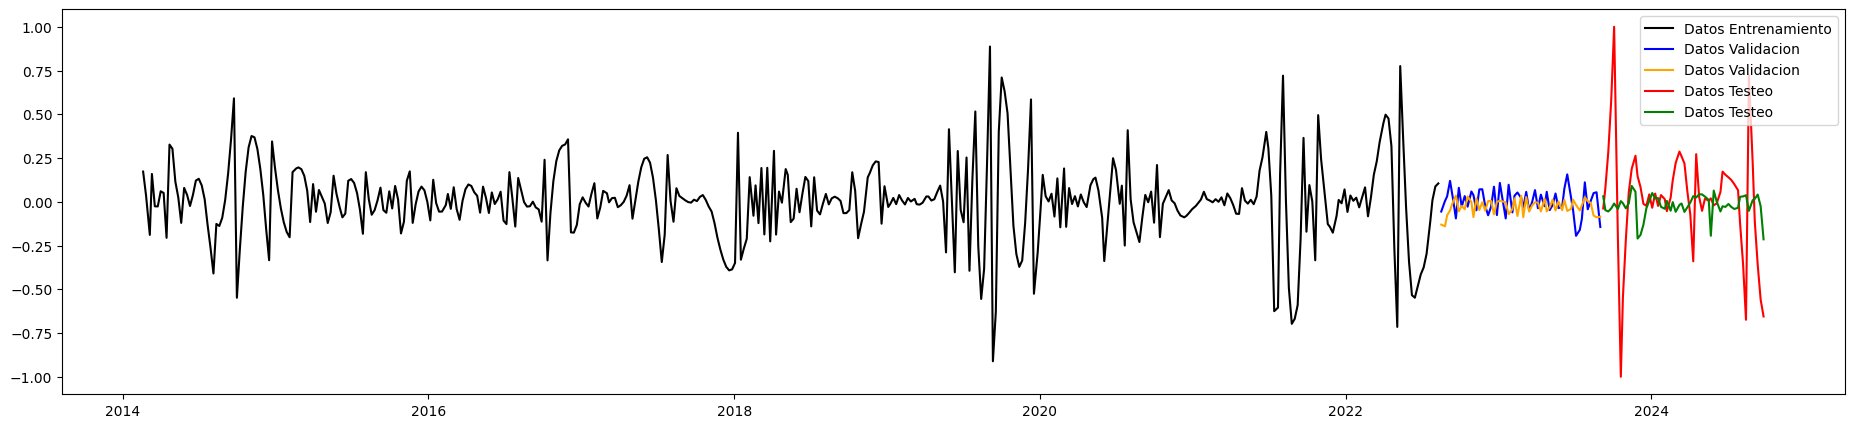

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
datos_validacion_m1

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2022-08-17,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173,-0.375279,-0.415655
2022-08-26,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173,-0.375279
2022-08-31,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953,-0.297173
2022-09-07,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289,-0.107953
2022-09-14,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837,0.009289
2022-09-21,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793,0.087837
2022-09-28,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714,0.104793
2022-10-05,-0.028180,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814,-0.055714
2022-10-12,0.032536,-0.028180,0.079835,-0.095035,0.017962,0.119458,0.030425,0.004814


In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.PROMEDIO))
print(score)

0.09237557


In [ ]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

# Modelamos modo 2

In [ ]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053


In [ ]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values
datos_validacion_m2_values = datos_validacion_m2.values
datos_testeo_m2_values = datos_testeo_m2.values

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


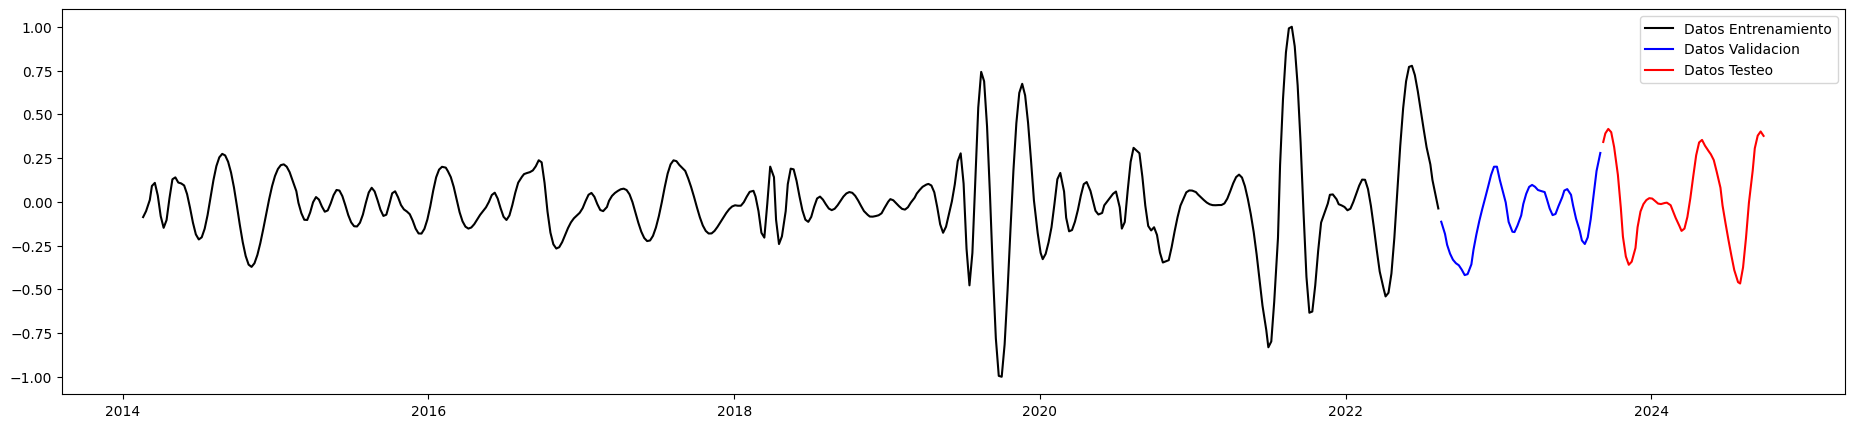

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
def modeloRD_m2():
  modelo = Sequential()
  modelo.add(Dense(units=46, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=63,  activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0037), loss='mse')
  return modelo


In [ ]:
modelo = modeloRD_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 16/40
63/63 ━

In [ ]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


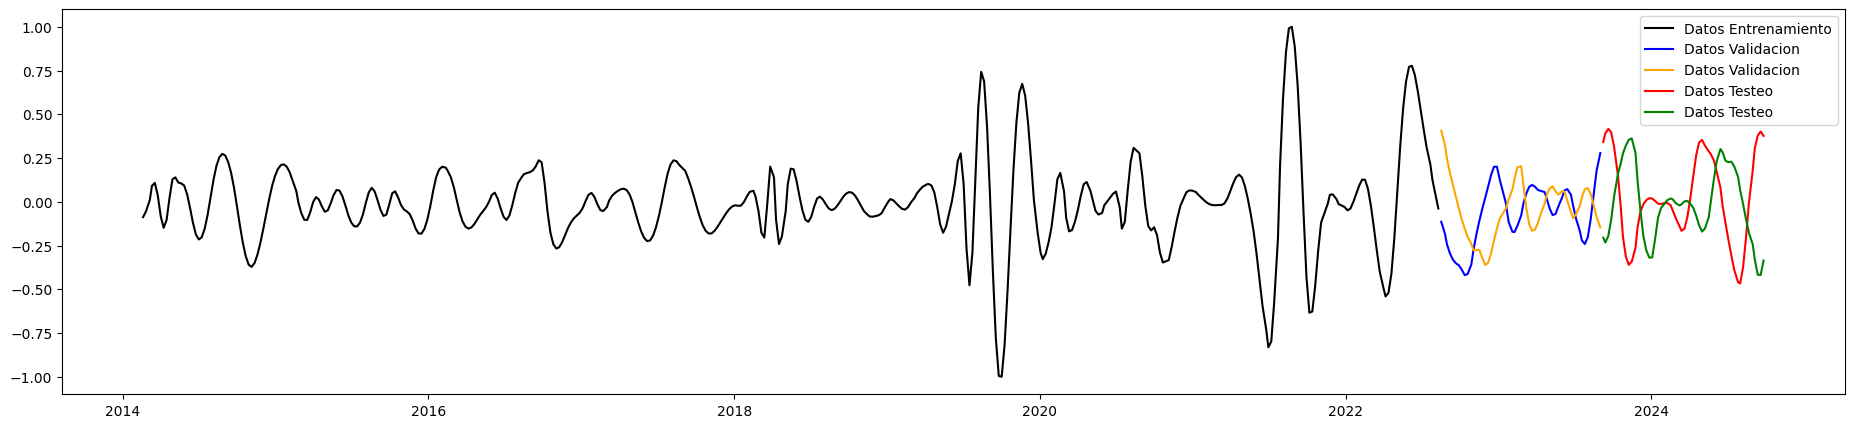

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta actualmente en 0.2015

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.PROMEDIO))
print(score)

0.26691303


In [ ]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos modo 3

In [ ]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = add_lags(modo_3_escalado, PASOS)
modo_3_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387,-0.699896,-0.677202
2014-02-26,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387,-0.699896
2014-03-07,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387
2014-03-12,-0.578597,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900
2014-03-19,-0.515235,-0.578597,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665


In [ ]:
total_datos=len(modo_3_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

datos_entrenamiento_m3_values= datos_entrenamiento_m3.values
datos_validacion_m3_values = datos_validacion_m3.values
datos_testeo_m3_values = datos_testeo_m3.values

X_train, y_train = datos_entrenamiento_m3_values[:, :-1], datos_entrenamiento_m3_values[:, -1]
X_val, y_val = datos_validacion_m3_values[:, :-1], datos_validacion_m3_values[:, -1]
X_test, y_test = datos_testeo_m3_values[:, :-1], datos_testeo_m3_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


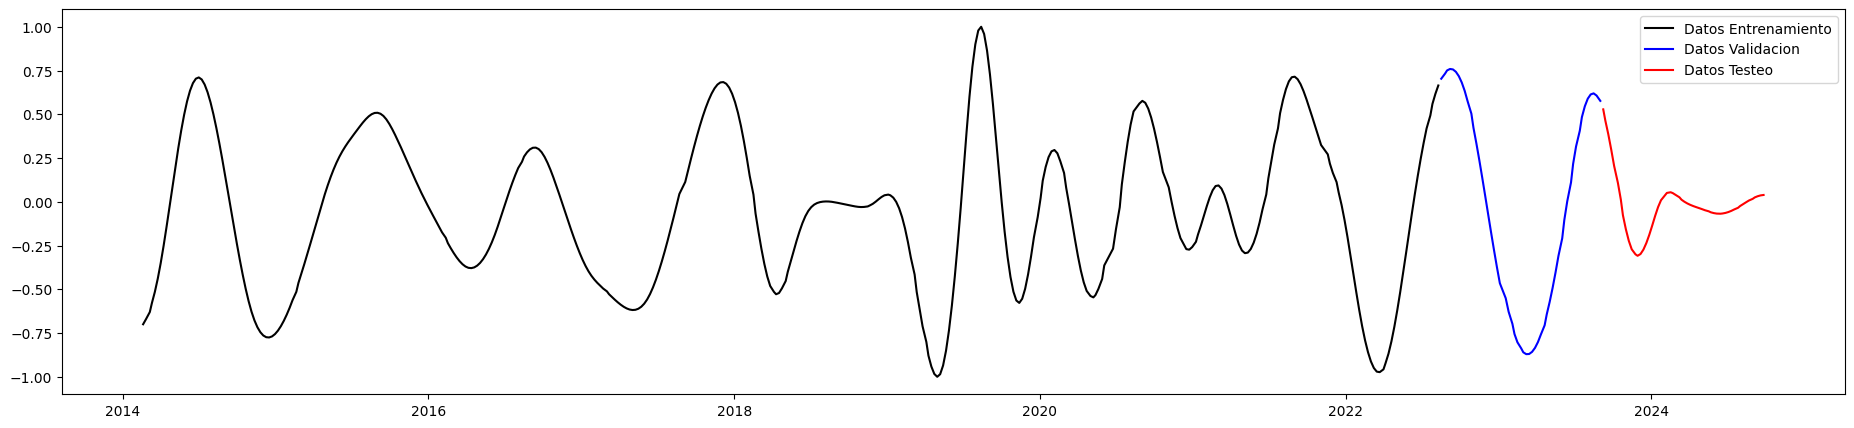

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
def modeloRD_m3():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  #modelo.add(Dense(units=53, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=RMSprop(learning_rate=0.0218), loss='mse')
  return modelo


In [ ]:
modelo = modeloRD_m3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0791
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 16/40
63/63 ━━━━━━━━━━━━

In [ ]:
prediccion_validacion_m3 = modelo.predict(X_val)
prediccion_testeo_m3 = modelo.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


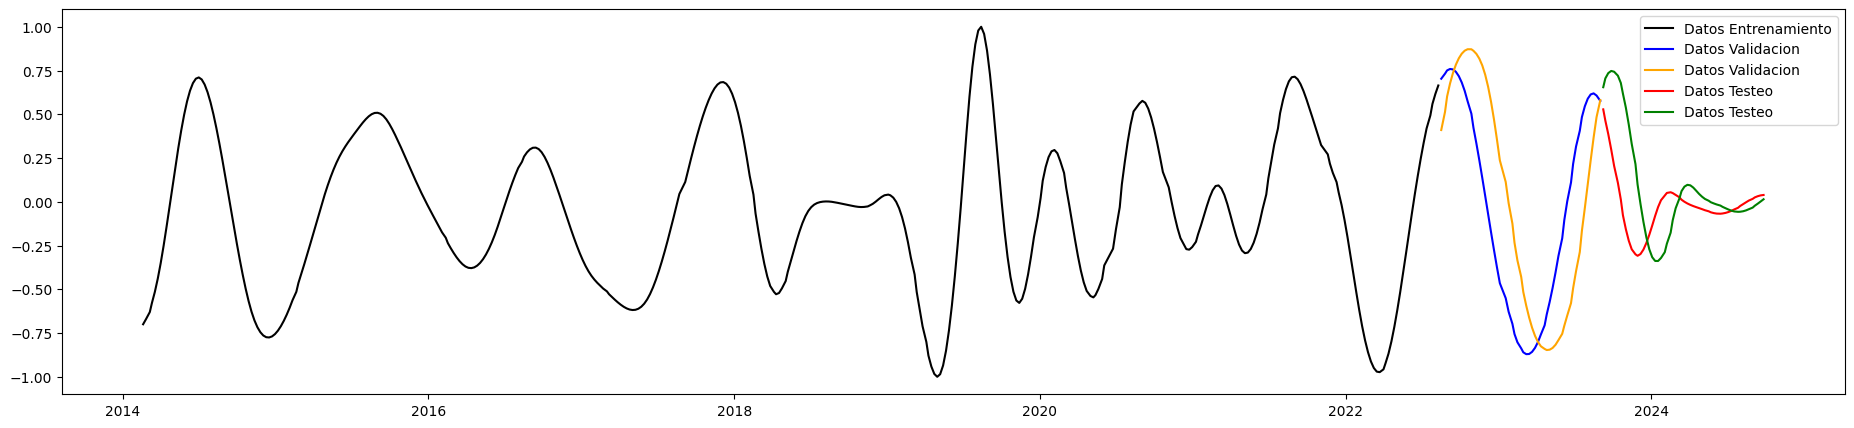

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m3.index,prediccion_validacion_m3,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m3.index,prediccion_testeo_m3,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m3,datos_validacion_m3.PROMEDIO))
print(score)

0.46828398


In [ ]:
prediccion_validacion_m3 = modo_3_scaler.inverse_transform(prediccion_validacion_m3)
prediccion_testeo_m3 = modo_3_scaler.inverse_transform(prediccion_testeo_m3 )

# modelamos modo 4


In [ ]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = add_lags(modo_4_escalado, PASOS)
modo_4_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090,0.259776,0.261531
2014-02-26,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090,0.259776
2014-03-07,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090
2014-03-12,0.245824,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460
2014-03-19,0.244376,0.245824,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870


In [ ]:
total_datos=len(modo_4_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

datos_entrenamiento_m4_values= datos_entrenamiento_m4.values
datos_validacion_m4_values = datos_validacion_m4.values
datos_testeo_m4_values = datos_testeo_m4.values

X_train, y_train = datos_entrenamiento_m4_values[:, :-1], datos_entrenamiento_m4_values[:, -1]
X_val, y_val = datos_validacion_m4_values[:, :-1], datos_validacion_m4_values[:, -1]
X_test, y_test = datos_testeo_m4_values[:, :-1], datos_testeo_m4_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


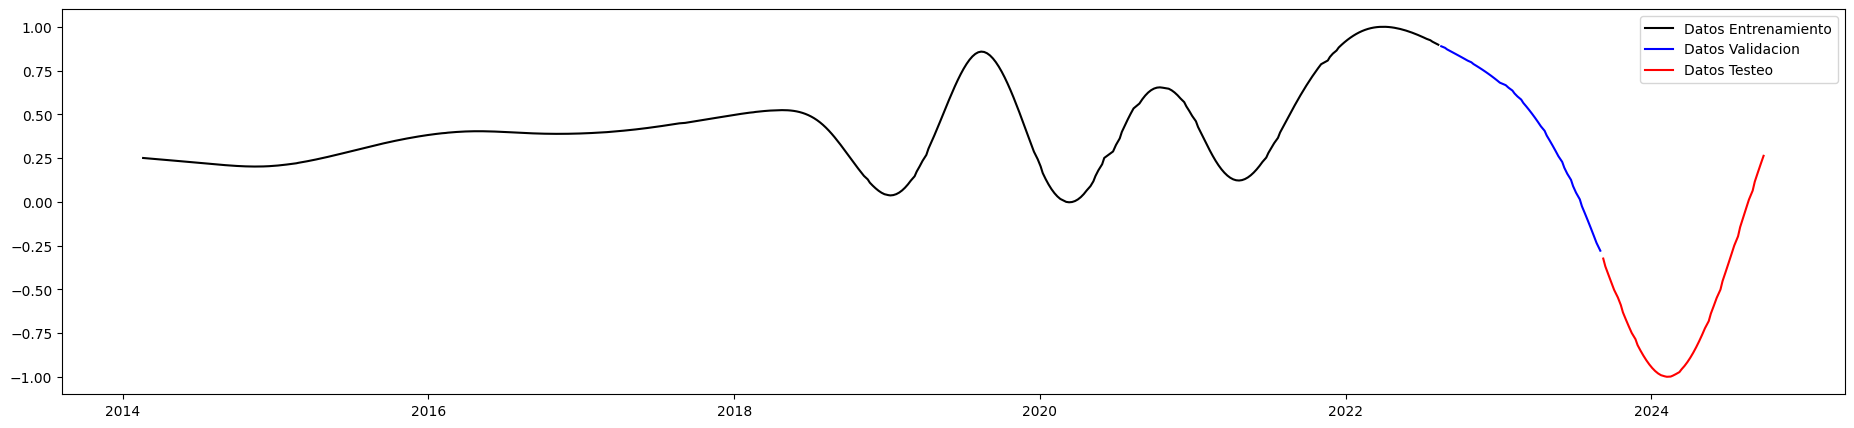

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
def modeloRD_m4():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo


In [ ]:
modelo = modeloRD_m4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0899
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0590e-04
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5246e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1381e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3954e-05
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3592e-04
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1614e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2137e-04
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0617e-04
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.682

In [ ]:
prediccion_validacion_m4 = modelo.predict(X_val)
prediccion_testeo_m4 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


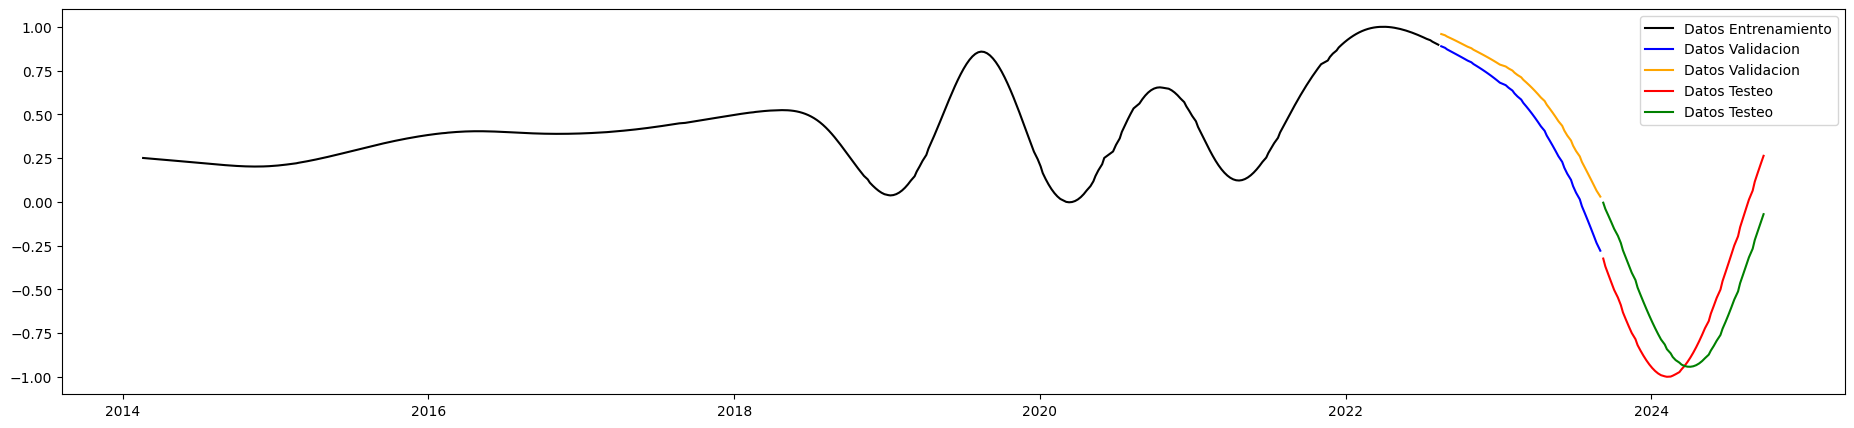

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m4.index,prediccion_validacion_m4,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m4.index,prediccion_testeo_m4,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

estamos en 0.047998

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m4,datos_validacion_m4.PROMEDIO))
print(score)

0.16649832


In [ ]:
prediccion_validacion_m4 = modo_4_scaler.inverse_transform(prediccion_validacion_m4)
prediccion_testeo_m4 = modo_4_scaler.inverse_transform(prediccion_testeo_m4 )

# Modelamos modo 5

In [ ]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = add_lags(modo_5_escalado, PASOS)
modo_5_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221,-0.645525,-0.656767
2014-02-26,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221,-0.645525
2014-03-07,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221
2014-03-12,-0.541988,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860
2014-03-19,-0.530285,-0.541988,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443


In [ ]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values
datos_validacion_m5_values = datos_validacion_m5.values
datos_testeo_m5_values = datos_testeo_m5.values

X_train, y_train = datos_entrenamiento_m5_values[:, :-1], datos_entrenamiento_m5_values[:, -1]
X_val, y_val = datos_validacion_m5_values[:, :-1], datos_validacion_m5_values[:, -1]
X_test, y_test = datos_testeo_m5_values[:, :-1], datos_testeo_m5_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


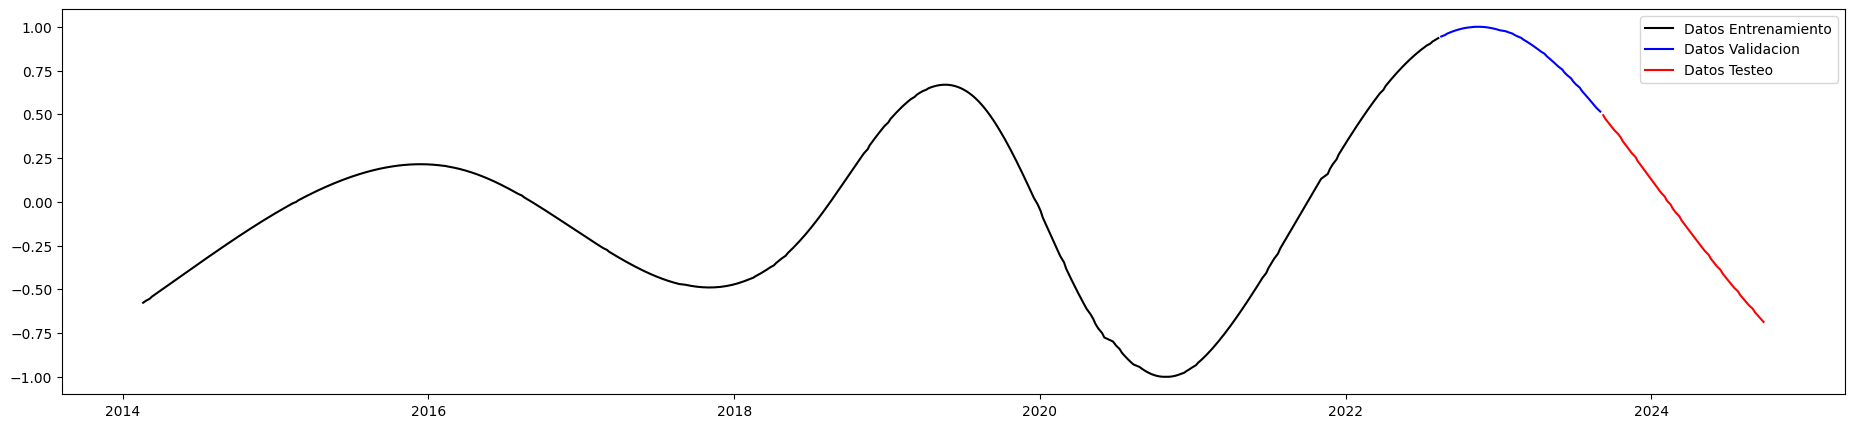

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [ ]:
def modeloRD_m5():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [ ]:
modelo = modeloRD_m5()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6590e-04
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2187e-04
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5632e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8986e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6855e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2228e-04
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0502e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5267e-05
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0467e-04
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7

In [ ]:
prediccion_validacion_m5 = modelo.predict(X_val)
prediccion_testeo_m5 = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


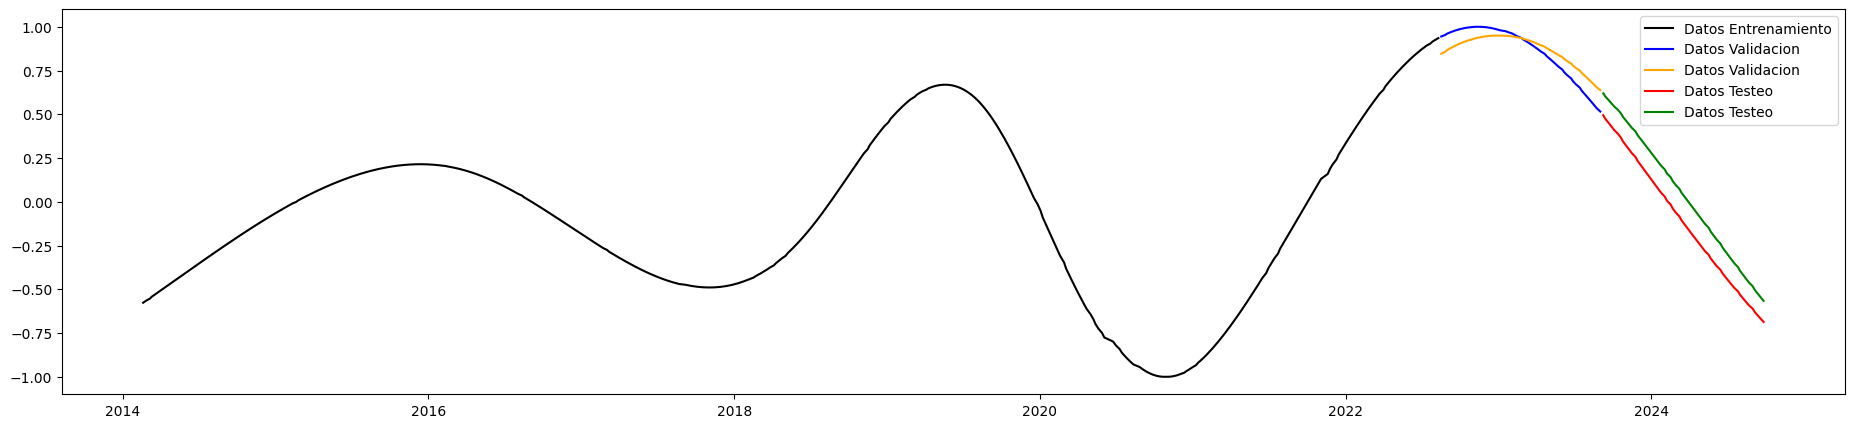

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,prediccion_validacion_m5,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_testeo_m5,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

esta en 0.013

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m5,datos_validacion_m5.PROMEDIO))
print(score)

0.07080086


In [ ]:
prediccion_validacion_m5 = modo_5_scaler.inverse_transform(prediccion_validacion_m5)
prediccion_testeo_m5 = modo_5_scaler.inverse_transform(prediccion_testeo_m5 )

# Modelamos Residuo

In [ ]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407,-0.996204,-1.000000
2014-02-26,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407,-0.996204
2014-03-07,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407
2014-03-12,-0.962039,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610
2014-03-19,-0.958249,-0.962039,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812


In [ ]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(437, 1, 7) (437,) (54, 1, 7) (54,) (56, 1, 7) (56,)


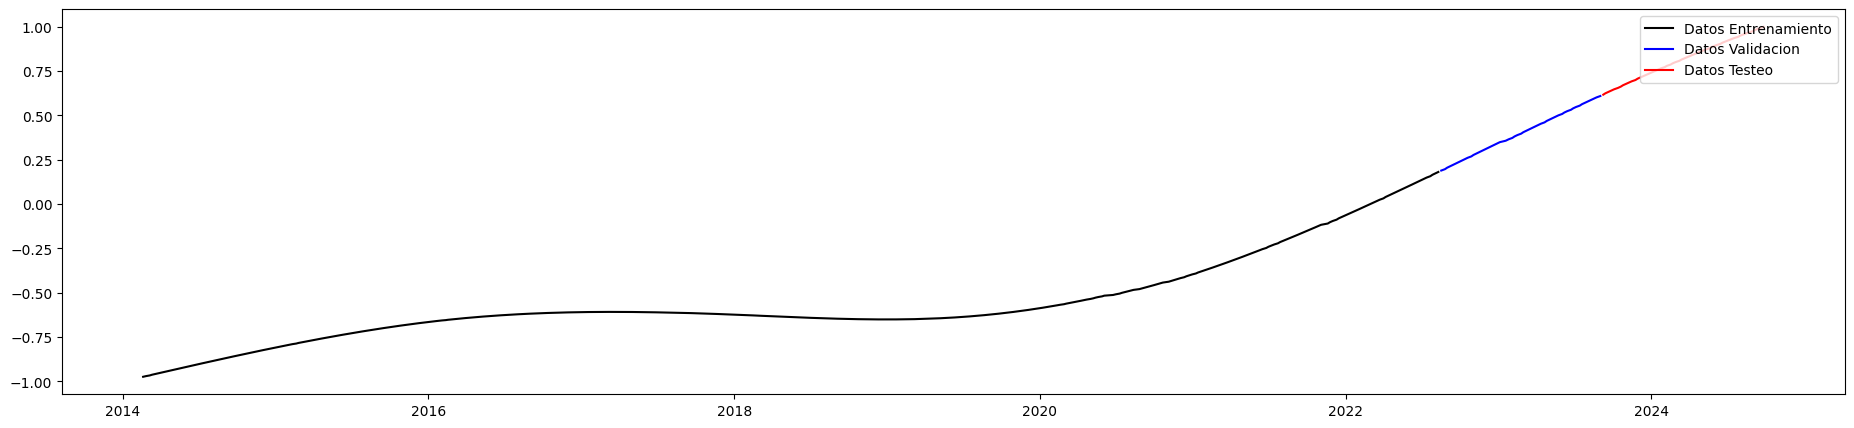

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
def modeloRD_residuo():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Dense(units=50, activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [ ]:
modelo = modeloRD_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9255e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9288e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8481e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7025e-04
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6297e-04
Epoch 16/4

In [ ]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


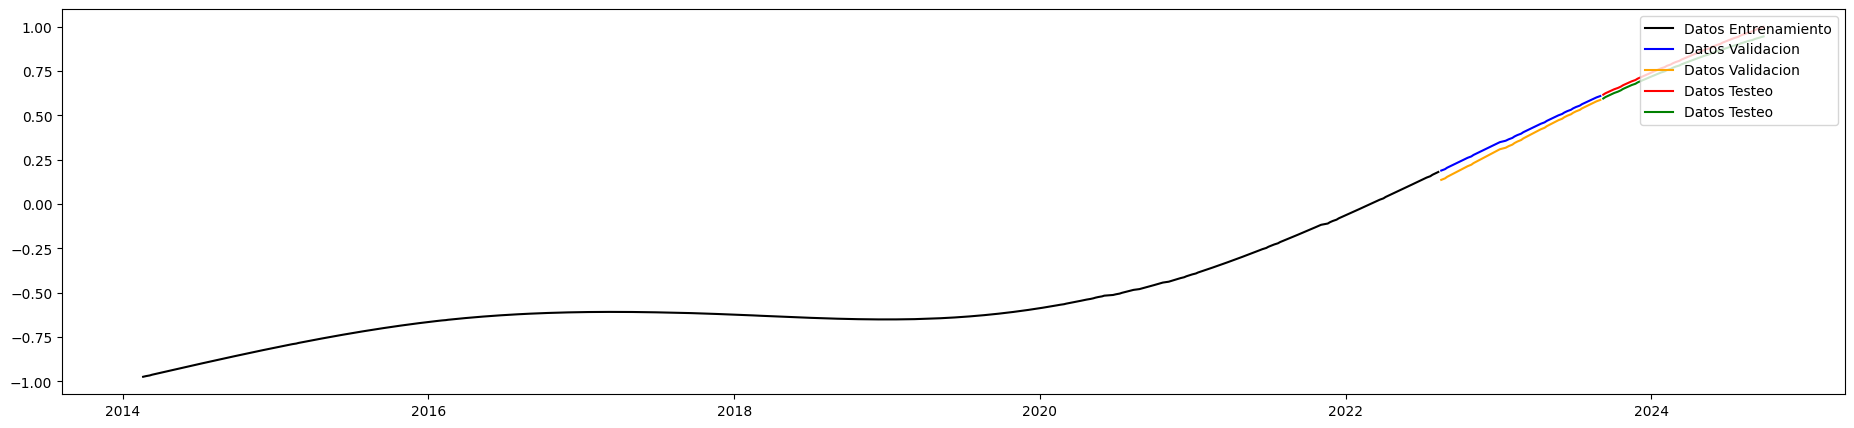

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

el score esta en 12.27

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m5,datos_validacion_m5.PROMEDIO))
print(score)

246.70413


In [ ]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
datos_emd
validacion = prediccion_validacion_m1 +prediccion_validacion_m2 + prediccion_validacion_m3 + prediccion_validacion_m4 + prediccion_validacion_m5 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m1 +prediccion_testeo_m2 + prediccion_testeo_m3 + prediccion_testeo_m4 + prediccion_testeo_m5 + prediccion_testeo_residuo

In [ ]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [ ]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 84.4566592652114 
el error absoluto medio del modelo es: 65.94868073640062 
Error porcentual absoluto medio del modelo es: 0.02438973139812176


In [ ]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.PROMEDIO))
eam = mean_absolute_error( testeo,datos_testeo.PROMEDIO)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.PROMEDIO)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 227.39163362466067 
el error absoluto medio del modelo es: 150.03096880231493 
Error porcentual absoluto medio del modelo es: 0.06445232003301213


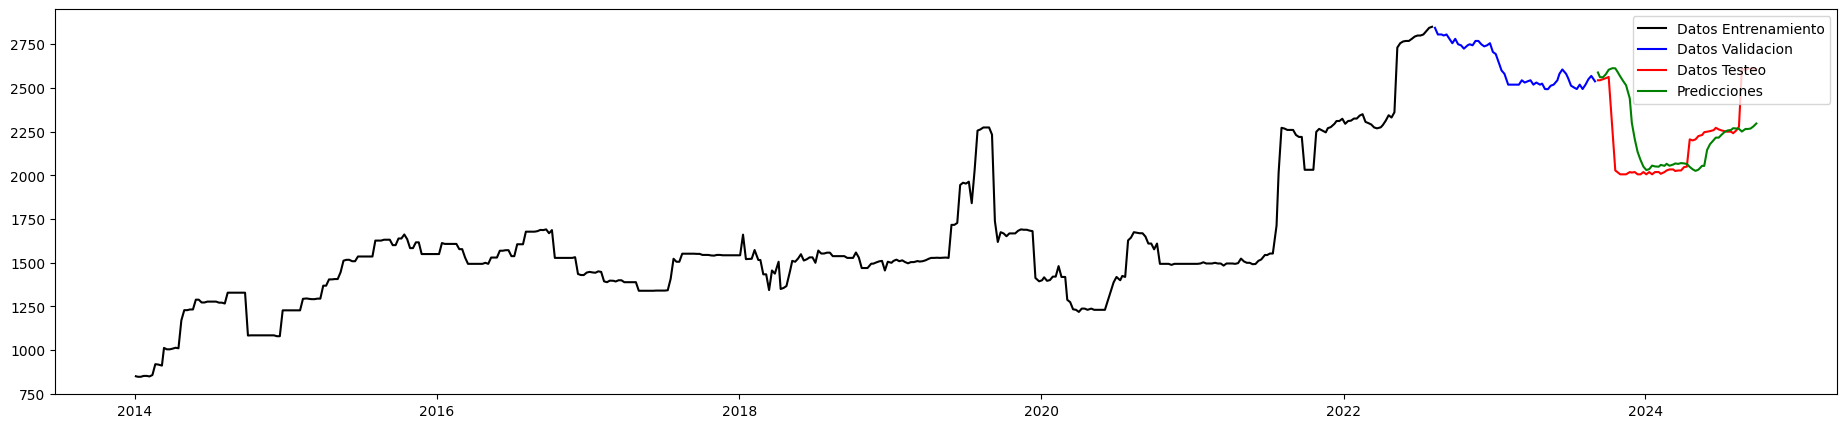

In [ ]:

fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

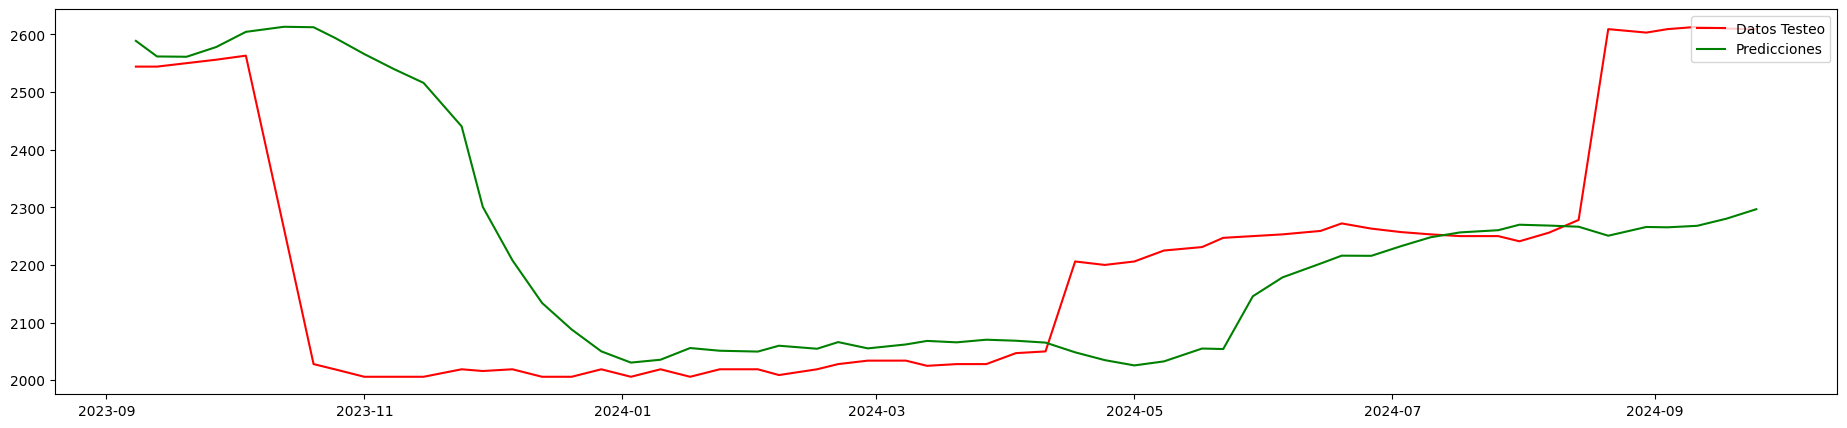

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(testeo,index=datos_testeo.index,columns=['Precio_Cierre'])

In [ ]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/validacion_red_densa.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/testeo_red_densa.csv",index=True)
